In [ ]:
!pip install wfdb

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.1/

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [2]:
cd '/content/drive/My Drive/DSL'

/content/drive/My Drive/DSL


In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/content/drive/My Drive/DSL/physionet.org/files/ptb-xl/1.0.1/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test (https://physionet.org/content/ptb-xl/1.0.1/)
test_fold = 10
dev_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != dev_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != dev_fold)].diagnostic_superclass
#Dev
X_dev = X[np.where(Y.strat_fold == dev_fold)]
y_dev = Y[(Y.strat_fold == dev_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [37]:
import pickle
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [4]:
X_train.shape

(17441, 1000, 12)

In [5]:
y_train.shape

(17441,)

In [6]:
X_dev.shape

(2193, 1000, 12)

In [7]:
y_dev.shape

(2193,)

In [8]:
X_test.shape

(2203, 1000, 12)

In [9]:
y_test.shape

(2203,)

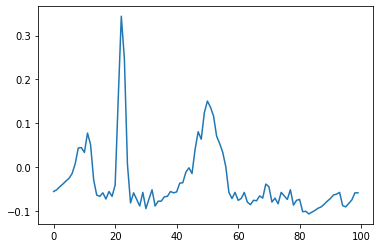

In [10]:
import matplotlib.pyplot as plt
plt.plot(X_train[0][:100,1])

In [ ]:
for elm in y_train:
  print(elm)

In [12]:
y_train

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21832      [CD]
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
Name: diagnostic_superclass, Length: 17441, dtype: object

In [13]:
cd '/content/drive/My Drive/DSL'

/content/drive/My Drive/DSL


In [14]:
import pickle
pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("X_dev.pickle","wb")
pickle.dump(X_dev, pickle_out)
pickle_out.close()

pickle_out = open("y_dev.pickle","wb")
pickle.dump(y_dev, pickle_out)
pickle_out.close()

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [ ]:
for ecg in X_train: 
  print(ecg.shape)

<font color=#c33432, size=6>Pre-Processing</font>

In [26]:
def labelstovector(X,y):
  '''
  Convert the labels in y into vectors:
  Multi-label problem:
  Norm: [0,0,0,0]
  MI: [1,0,0,0]
  STTC: [0,1,0,0]
  CD: [0,0,1,0]
  HYP: [0,0,0,1]
  Combination example:
  HYP and MI: [1,0,0,1]
  HYP and CD and STTC: [0,1,1,1]
  -----------------------------------------------------------
  Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
  '''
  y_list = []
  X_list = []
  for label, ecg in zip(y,X):
    if len(label)!=0: #ignore examples with label = []
      aux_vec = np.zeros(4)
      if 'MI' in label:
        aux_vec[0] = 1
      if 'STTC' in label:
        aux_vec[1] = 1
      if 'CD' in label:
        aux_vec[2] = 1
      if 'HYP' in label:
        aux_vec[3] = 1

      #print(label)
      #print(aux_vec)
      y_list.append(aux_vec)
      #print(ecg.shape)
      X_list.append(ecg)	

  return X_list, y_list

In [27]:
X_train_processed, y_train_processed = labelstovector(X_train, y_train)
X_dev_processed, y_dev_processed = labelstovector(X_dev, y_dev)
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)
print(y_test.shape)

(17441, 1000, 12)
(17441,)
(2193, 1000, 12)
(2193,)
(2203, 1000, 12)
(2203,)


In [33]:
print(np.asarray(X_train_processed).shape)
print(np.asarray(y_train_processed).shape)
print(np.asarray(X_dev_processed).shape)
print(np.asarray(y_dev_processed).shape)
print(np.asarray(X_test_processed).shape)
print(np.asarray(y_test_processed).shape)

(17111, 1000, 12)
(17111, 4)
(2156, 1000, 12)
(2156, 4)
(2163, 1000, 12)
(2163, 4)


In [36]:
import pickle
pickle_out = open("X_train_processed.pickle","wb")
pickle.dump(X_train_processed, pickle_out)
pickle_out.close()

pickle_out = open("y_train_processed.pickle","wb")
pickle.dump(y_train_processed, pickle_out)
pickle_out.close()

pickle_out = open("X_dev_processed.pickle","wb")
pickle.dump(X_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open("y_dev_processed.pickle","wb")
pickle.dump(y_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open("X_test_processed.pickle","wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open("y_test_processed.pickle","wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()